# Prediction

#### Prediction Problem:
Predicting adoption at the census block group level

In [1]:
# dependencies

import pandas as pd
pd.set_option("display.max_columns", 57)
import numpy as np
from numpy.linalg import inv
import statsmodels as sm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble

import statsmodels.api as smdd

### 1. Predicting EV Adoption at the Census Block Group Level

*We chose to exclude two observations in this section because their Proportion EV values are significantly larger than the rest of the observations and we didn't want two outliers to skew our overall predicting power.*

In [2]:
# read in the datafame

df = pd.read_csv("data/df_proportions.csv")
df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], inplace=True)

In [3]:
# remove the outliers

df1 = df.loc[df["Proportion EV"]<0.2]

#### Data Standardization
We chose to standardize the values for all of our features, given that we plan to use Lasso and Ridge regression methods. It is worth noting that using proportions does somewhat normalize all of the data to be values between 0 and 1, however, we chose to use the standard scaler to ensure our data was normalized with mean = 0 and variance = 1. 

In [4]:
X = df1.loc[:, "More College Completed Proportion":
                           "90 or more Minutes Proportion"]
y = df1[["Proportion EV"]]

In [5]:
scaler = StandardScaler() #initialize scaler
#standardize features
scaler.fit(X)  
X_stnd = scaler.transform(X) 
#standardize response variables
scaler.fit(y)
y_stnd = scaler.transform(y) 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_stnd, y_stnd, test_size=0.2, random_state=1)

#### Prediction Model 1.1 - MLR

We build a multiple linear regression model on the training data and use those parameter estimates to predict the values of our target in the testing data and training data and use those predictions to calculate a test RMSE and a train RMSE. The test RMSE is constructed to evaluate the performance of this model relative to other models we will build (Ridge, Lasso, and Regression Tree).

In [7]:
MLR_model = LinearRegression()
MLR_fit = MLR_model.fit(X_train, y_train)
y_pred_test = MLR_fit.predict(X_test)
y_pred_train = MLR_fit.predict(X_train)
print("test RMSE:", mean_squared_error(y_test, y_pred_test, squared = False))
print("train RMSE:", mean_squared_error(y_train, y_pred_train, squared = False))
print("R^2 test:", r2_score(y_test, y_pred_test))
print("R^2 train:", r2_score(y_train, y_pred_train))
MLR_coefs = MLR_fit.coef_
MLR_coefs

test RMSE: 0.5970427288520374
train RMSE: 0.5923313023117363
R^2 test: 0.6368467083303749
R^2 train: 0.650745817656428


array([[ 2.96224072e-01,  8.80701062e-02, -3.29434264e-02,
         7.94107394e+11,  1.49860485e+12,  1.58136389e+12,
         1.61822957e+12,  1.88008985e+12,  1.81343586e+12,
         4.85490596e-02, -4.02899597e-03, -5.78940275e-04,
         7.27319300e-02,  1.43231111e-03,  3.76603644e-02,
         4.76111899e+12,  6.46906528e+12,  5.21398649e+12,
         5.54447187e+12,  3.57132300e+12,  3.58006074e+12,
         2.35138665e+12]])

We observe that our train RMSE and our test RMSE are already very similar, before even implementing any sort of regularization approach. We see that the train RMSE is slightly lower than the test RMSE, but we expected this difference to be larger.

*Let's visualize how far off each predictions is from the actual obervation by graphing the residuals for the training data and then for the testing data*

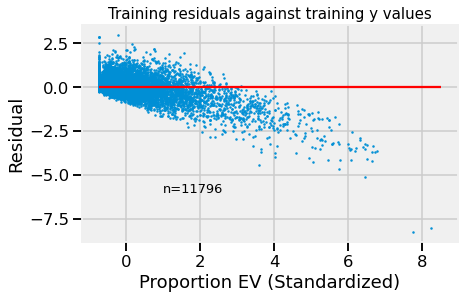

In [8]:
# training

residuals = y_pred_train - y_train

# Scatter the residuals on the y_train values
plt.scatter(y_train, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Training residuals against training y values", size=15)
plt.hlines(0, y_train.min(), 8.5, colors="red")
plt.text(1, -6, "n=11796", size=13);

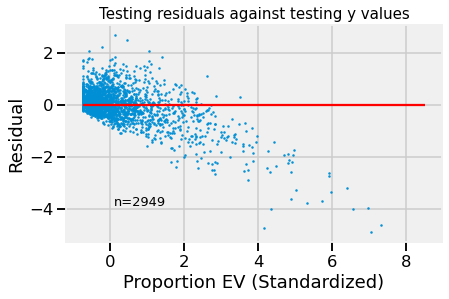

In [9]:
# testing

residuals = y_pred_test - y_test

# Scatter the residuals on the y_test values
plt.scatter(y_test, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Testing residuals against testing y values", size=15)
plt.hlines(0, y_test.min(), 8.5, colors="red")
plt.text(0.1, -3.9, "n=2949", size=13);

It looks like we're systematically over predicting for small values of y and systematically under predicting for large values of y. This may be evidence that linear regression is simply not appropriate for this prediction question. We will now turn to two regularization methods to address the potential problem over data overfit: Ridge and Lasso.

#### Prediction Model 1.2 - Ridge Regression
We move now to the first of our regularization methods. We include this model to check to see whether the multiple linear regression model suffered from a problem of overfitting data, a result of including too many features.

##### 5-fold CV
We first implemented a 5-fold cross validation to detmine the optimal size of the penalty coefficient, $\lambda$ (referred to as alpha here). We obtained an alpha value of 78.48. When applying the Ridge model to the test data set, we observe a slightly higher test RMSE for our ridge regression with 5-fold CV than we do for our original linear regression. As of this point, linear regression is our best model. 

We chose 5-fold because we understood that to be standard pratice, but to see whether or not the number of folds would affect our results, we decided to run another Ridge model using 15-fold CV to determine the optimal alpha.

**NOTE**: *this cell will take awhile to load*

In [10]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
grid = np.linspace(0.01, 100, 1000)
ridge_model = RidgeCV(cv = kf, alphas = grid)
ridge_fit = ridge_model.fit(X_train, y_train)


y_pred_ridge_test_5 = ridge_fit.predict(X_test)
y_pred_ridge_train_5 = ridge_fit.predict(X_train)
print("test RMSE:", mean_squared_error(y_test, y_pred_ridge_test_5, squared = False))
print("train RMSE:", mean_squared_error(y_train, y_pred_ridge_train_5, squared = False))
print("R2 test:", r2_score(y_test, y_pred_ridge_test_5))
print("R2 train:", r2_score(y_train, y_pred_ridge_train_5))
print("alpha:", ridge_fit.alpha_)
ridge_coefs = ridge_fit.coef_
ridge_coefs

test RMSE: 0.5974504814612387
train RMSE: 0.5923251523678589
R2 test: 0.6363505050945446
R2 train: 0.6507530699575022
alpha: 78.48063063063063


array([[ 0.29293678,  0.09100529, -0.03303619, -0.04222182, -0.06823353,
        -0.09124812, -0.10597162, -0.13852995,  0.39263336,  0.03168366,
        -0.01192523, -0.00165595,  0.05979496, -0.00132003,  0.02553477,
         0.00115809, -0.01998584,  0.0168765 ,  0.01157747,  0.01392109,
        -0.00612818, -0.023895  ]])

##### 15-fold CV
We also tried a 15-fold CV to see if the output alpha would give us a better test RMSE. The only notable difference between 5-fold CV and 15-fold CV, though, is that we obtain a higher alpha value of 93.89 (compared to 78.48). This means that we are penalizing additional features more heavily in our model building process than we did in the case of 5-fold CV. The test RMSE is larger with 15-fold CV by an extremely small order of magnitude (10^-6). 

**NOTE**: *this cell will take awhile to load*

In [11]:
kf = KFold(n_splits = 15, shuffle = True, random_state = 1)
grid = np.linspace(0.01, 100, 1000)
ridge_model = RidgeCV(cv = kf, alphas = grid)
ridge_fit = ridge_model.fit(X_train, y_train)


y_pred_ridge_test_15 = ridge_fit.predict(X_test)
y_pred_ridge_train_15 = ridge_fit.predict(X_train)
print("test RMSE:", mean_squared_error(y_test, y_pred_ridge_test_15, squared = False))
print("train RMSE:", mean_squared_error(y_train, y_pred_ridge_train_15, squared = False))
print("R2 test:", r2_score(y_test, y_pred_ridge_test_15))
print("R2 train:", r2_score(y_train, y_pred_ridge_train_15))
print("alpha:", ridge_fit.alpha_)
ridge_coefs = ridge_fit.coef_
ridge_coefs

test RMSE: 0.5974520510257225
train RMSE: 0.5923324364614464
R2 test: 0.6363485944020296
R2 train: 0.6507444802058922
alpha: 93.8945045045045


array([[ 0.29221638,  0.09183542, -0.03301985, -0.04216166, -0.06807882,
        -0.0911365 , -0.10598241, -0.1381885 ,  0.39203745,  0.02990957,
        -0.01281216, -0.00186545,  0.05844207, -0.00147402,  0.02432825,
         0.00109582, -0.01999475,  0.01689218,  0.01160823,  0.01393699,
        -0.00611774, -0.02389173]])

*Let's visualize how far off each predictions is from the actual obervation just for the case of 5-fold CV.*

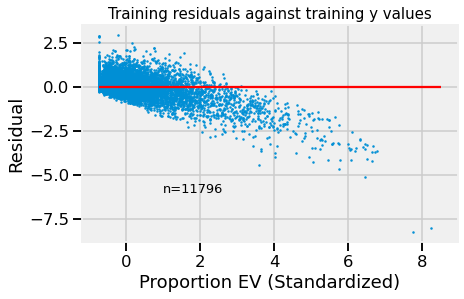

In [12]:
# training

residuals = y_pred_ridge_train_5 - y_train

# Scatter the residuals on the y_train values
plt.scatter(y_train, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Training residuals against training y values", size=15)
plt.hlines(0, y_train.min(), 8.5, colors="red")
plt.text(1, -6, "n=11796", size=13);

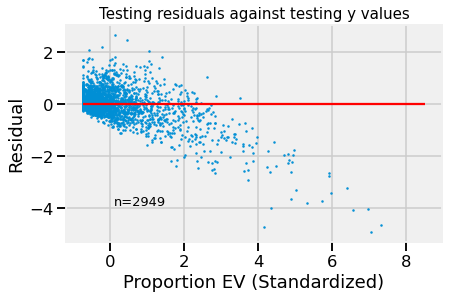

In [13]:
# testing

residuals = y_pred_ridge_test_5 - y_test

# Scatter the residuals on the y_test values
plt.scatter(y_test, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Testing residuals against testing y values", size=15)
plt.hlines(0, y_test.min(), 8.5, colors="red")
plt.text(0.1, -3.9, "n=2949", size=13);

We continue to observe that we have a problem of underpredicting the value of our target variable (Proportion EV) for large values of this variable.

#### Prediction Model 1.3 - Lasso Regression
We turn now to our second regularization model, Lasso. As was the case for Ridge, we will need to begin by determining our ideal hyerparameter alpha. To do this, we try one model which utilizes 5-fold CV and another model which utilizes 15-fold CV. In each model, we use the alpha found through CV to build the model on the training data, then we apply the model to our test data to see how it performs relative to linear regression and ridge.

##### 5-fold CV

In [14]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
grid = np.linspace(0.01, 100, 1000)
lasso_model = LassoCV(cv = kf, alphas = grid)
lasso_fit = lasso_model.fit(X_train, y_train)


y_pred_lasso_test = lasso_fit.predict(X_test)
y_pred_lasso_train = lasso_fit.predict(X_train)
print("test RMSE:", mean_squared_error(y_test, y_pred_lasso_test, squared = False))
print("train RMSE:", mean_squared_error(y_train, y_pred_lasso_train, squared = False))
print("R2 test:", r2_score(y_test, y_pred_lasso_test))
print("R2 train:", r2_score(y_train, y_pred_lasso_train))
print("alpha:", lasso_fit.alpha_)
lasso_coefs = lasso_fit.coef_
lasso_coefs

/Users/cameronwright/Desktop/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test RMSE: 0.5972230187271781
train RMSE: 0.593714769622557
R2 test: 0.6366273513432918
R2 train: 0.649112454673025
alpha: 0.01


array([ 0.30747385,  0.03704383, -0.00459413,  0.        ,  0.00472323,
       -0.        , -0.01174558, -0.02125518,  0.49850594, -0.        ,
       -0.01559882, -0.        ,  0.03297258, -0.        ,  0.        ,
       -0.        , -0.01616737,  0.0075399 ,  0.00499849,  0.00194969,
       -0.        , -0.02008017])

We determine the ideal alpha to be 0.01 for 5-fold CV Lasso Regression, making this model nearly identical to our linear regression model (which can be thought of as having an alpha of 0). We see that Lasso with 5-fold CV returns a slightly larger test RMSE than the linear regression model, but smaller than the Ridge regression model.

##### 15-fold CV

In [15]:
kf = KFold(n_splits = 15, shuffle = True, random_state = 1)
grid = np.linspace(0.01, 100, 1000)
lasso_model = LassoCV(cv = kf, alphas = grid)
lasso_fit = lasso_model.fit(X_train, y_train)


y_pred_lasso_test = lasso_fit.predict(X_test)
y_pred_lasso_train = lasso_fit.predict(X_train)
print("test RMSE:", mean_squared_error(y_test, y_pred_lasso_test, squared = False))
print("train RMSE:", mean_squared_error(y_train, y_pred_lasso_train, squared = False))
print("R2 test:", r2_score(y_test, y_pred_lasso_test))
print("R2 train:", r2_score(y_train, y_pred_lasso_train))
print("alpha:", lasso_fit.alpha_)
lasso_coefs = lasso_fit.coef_
lasso_coefs

/Users/cameronwright/Desktop/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test RMSE: 0.5972230187271781
train RMSE: 0.593714769622557
R2 test: 0.6366273513432918
R2 train: 0.649112454673025
alpha: 0.01


array([ 0.30747385,  0.03704383, -0.00459413,  0.        ,  0.00472323,
       -0.        , -0.01174558, -0.02125518,  0.49850594, -0.        ,
       -0.01559882, -0.        ,  0.03297258, -0.        ,  0.        ,
       -0.        , -0.01616737,  0.0075399 ,  0.00499849,  0.00194969,
       -0.        , -0.02008017])

There is no difference when implementing 15-fold CV compared to 5-fold CV.

*Let's visualize how far off each predictions is from the actual obervation.*

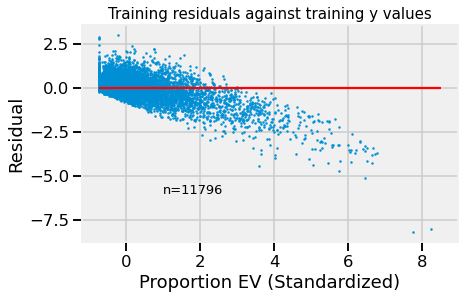

In [16]:
# training

y_train_new = [y_train[i][0] for i in range(len(y_train))]
y_pred_lasso_train_new = [value for value in y_pred_lasso_train]


residuals = [y_pred_lasso_train_new[i] - y_train_new[i] for i in range(len(y_train_new))]

# Scatter the residuals on the y_train values
plt.scatter(y_train_new, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Training residuals against training y values", size=15)
plt.hlines(0, y_train.min(), 8.5, colors="red")
plt.text(1, -6, "n=11796", size=13);

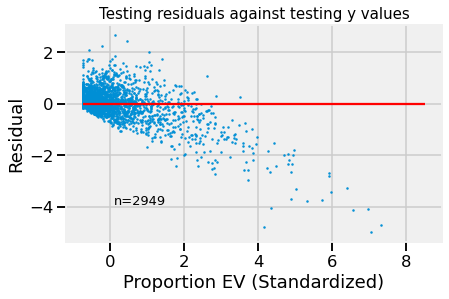

In [17]:
# testing

y_test_new = [y_test[i][0] for i in range(len(y_test))]
y_pred_lasso_test_new = [value for value in y_pred_lasso_test]


residuals = [y_pred_lasso_test_new[i] - y_test_new[i] for i in range(len(y_test_new))]

# Scatter the residuals on the y_train values
plt.scatter(y_test_new, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Testing residuals against testing y values", size=15)
plt.hlines(0, y_test.min(), 8.5, colors="red")
plt.text(0.1, -3.9, "n=2949", size=13);

We continue to observe the problem of under predicting for large values of Proportion EV.

#### Prediction Model 1.4 - Regression Tree
For our final model we chose to implement a regression tree in the hope that its non-parametric nature would correct our issue of systematically under predicting for large values of Proportion EV.

In [18]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state = 1)
regressor.fit(X_train, y_train)
y_pred_tree_test = regressor.predict(X_test)
y_pred_tree_train = regressor.predict(X_train)

print("test RMSE:", mean_squared_error(y_test, y_pred_tree_test, squared = False))
print("train RMSE:", mean_squared_error(y_train, y_pred_tree_train, squared = False))
print("R2 test:", r2_score(y_test, y_pred_tree_test))
print("R2 train:", r2_score(y_train, y_pred_tree_train))

test RMSE: 0.8243121875045484
train RMSE: 5.69696529176075e-17
R2 test: 0.307750581313496
R2 train: 1.0


Using default values for `max_leaf_nodes`, `max_features`, and `max_depth`, we obtain an extremely small train RMSE and more importantly a slightly larger test RMSE, 0.81702, than we do for each of our first three models (0.59704, 0.59745, and 0.59722 respecitvely). We will now decide what values to set for each of these hyperparameters using a gridsearch. 

**Determine ideal hyperparameters**

**NOTE**: *this cell will take awhile to load*

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 22),
              'max_depth': randint(1, 10)}

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_dist, 
                                cv=10, n_iter=200, random_state = 2020)
rnd_search.fit(X_train, y_train)

print(rnd_search.best_score_) 
print(rnd_search.best_params_)

0.6363022708853932
{'max_depth': 7, 'max_features': 15, 'max_leaf_nodes': 20}


In [20]:
regressor = DecisionTreeRegressor(random_state = 1, max_depth = 7, max_features = 15, 
                                  max_leaf_nodes = 20)
regressor.fit(X_train, y_train)
y_pred_tree_test = regressor.predict(X_test)
y_pred_tree_train = regressor.predict(X_train)

print("test RMSE:", mean_squared_error(y_test, y_pred_tree_test, squared = False))
print("train RMSE:", mean_squared_error(y_train, y_pred_tree_train, squared = False))
print("R2 test:", r2_score(y_test, y_pred_tree_test))
print("R2 train:", r2_score(y_train, y_pred_tree_train))

test RMSE: 0.5970587266664085
train RMSE: 0.574282717424998
R2 test: 0.6368272466184981
R2 train: 0.6717053985967233


We obtain a test RMSE of 0.59706, which is slightly higher than the test RMSE for our linear regression model.

Let's take a shot at visualizing what this model gives us.

In [22]:
from sklearn import tree
import graphviz

In [23]:
print(tree.export_graphviz(regressor, feature_names=X.columns))

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="$200k or more Proportion <= 0.764\nsquared_error = 1.005\nsamples = 11796\nvalue = 0.002"] ;
1 [label="College Completed Proportion <= 0.144\nsquared_error = 0.291\nsamples = 9658\nvalue = -0.302"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
5 [label="$200k or more Proportion <= -0.52\nsquared_error = 0.105\nsamples = 6680\nvalue = -0.492"] ;
1 -> 5 ;
17 [label="squared_error = 0.076\nsamples = 4363\nvalue = -0.558"] ;
5 -> 17 ;
18 [label="College Completed Proportion <= -0.378\nsquared_error = 0.136\nsamples = 2317\nvalue = -0.368"] ;
5 -> 18 ;
27 [label="squared_error = 0.087\nsamples = 1201\nvalue = -0.478"] ;
18 -> 27 ;
28 [label="squared_error = 0.162\nsamples = 1116\nvalue = -0.25"] ;
18 -> 28 ;
6 [label="$200k or more Proportion <= -0.221\nsquared_error = 0.444\nsamples = 2978\nvalue = 0.126"] ;
1 -> 6 ;
11 [label="squared_error = 0.231\nsamples = 1111\nvalue = -0.

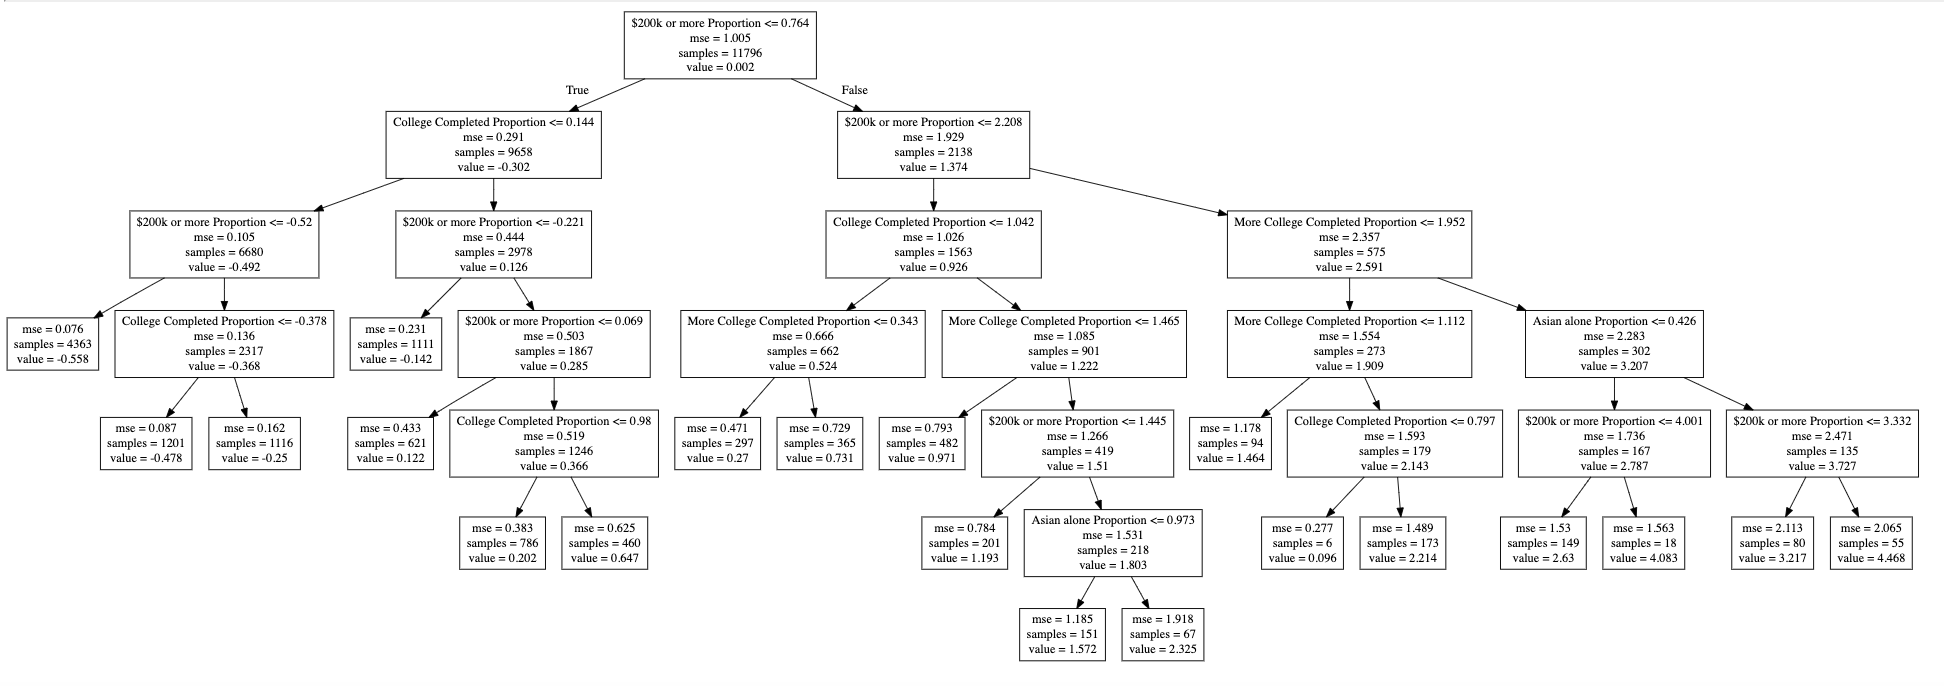

In [25]:
from IPython.display import Image
Image(filename='Output2.png')

Below, we utilize the same residual visualization that we've been using throughout.

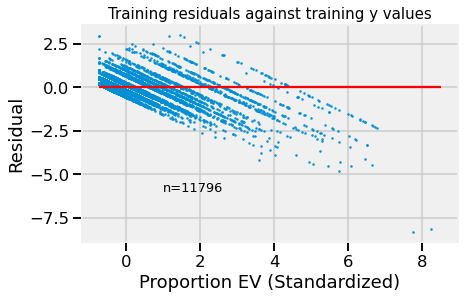

In [27]:
# training

y_train_new = [y_train[i][0] for i in range(len(y_train))]
y_pred_tree_train_new = [value for value in y_pred_tree_train]

residuals = [y_pred_tree_train_new[i] - y_train_new[i] for i in range(len(y_train_new))]

# Scatter the residuals on the y_train values
plt.scatter(y_train_new, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Training residuals against training y values", size=15)
plt.hlines(0, y_train.min(), 8.5, colors="red")
plt.text(1, -6, "n=11796", size=13);

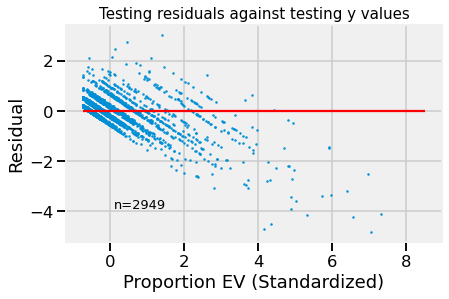

In [28]:
# testing

y_test_new = [y_test[i][0] for i in range(len(y_test))]
y_pred_tree_test_new = [value for value in y_pred_tree_test]


residuals = [y_pred_tree_test_new[i] - y_test_new[i] for i in range(len(y_test_new))]

# Scatter the residuals on the y_train values
plt.scatter(y_test_new, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Testing residuals against testing y values", size=15)
plt.hlines(0, y_test.min(), 8.5, colors="red")
plt.text(0.1, -3.9, "n=2949", size=13);

We observe the same issue of under predicting for large values of Proportion EV using regression trees. The predictions using the tree are stratefied in horizontal lines because regression trees output discontinuous predictions. Each horizontal grouping corresponds to a different terminal node in the tree.

### Training on NorCal and Testing on SoCal
To simulate if this model can be performed on other states, we'll split of California into 2 regions: Northern and Southern.

Let's split our data between those located in counties in Northern California versus those located in Southern California and made a train test split, with Northern CA census block group data being the training set, and Southern CA census block group data as the test set.

In [29]:
norcal_counties = ['DEL NORTE', 'SISKIYOU', 'MODOC', 'HUMBOLDT', 'TRINITY', 'SHASTA', 'LASSEN', 'MENDOCINO', 'TEHAMA', 'PLUMAS',
                 'GLENN', 'BUTTE', 'SIERRA', 'LAKE', 'COLUSA', 'YUBA', 'NEVADA', 'PLACER', 'SUTTER', 'SONOMA', 'NAPA', 'YOLO',
                 'SACRAMENTO', 'EL DORADO', 'ALPINE', 'AMADOR', 'SOLANO', 'MARIN', 'CONTRA COSTA', 'SAN JOAQUIN', 'CALAVERAS', 
                 'TUOLUMNE', 'MONO', 'STANISLAUS', 'ALAMEDA', 'SAN FRANCISCO', 'SAN MATEO', 'SANTA CLARA', 'SANTA CRUZ', 
                 'MERCED', 'MARIPOSA', 'MADERA', 'SAN BENITO', 'MONTEREY', 'FRESNO', 'KINGS', 'TULARE', 'INYO']
socal_counties = ['SAN LUIS OBISPO', 'SANTA BARBARA', 'KERN', 'VENTURA', 'LOS ANGELES', 'SAN BERNARDINO', 'ORANGE',
                 'RIVERSIDE', 'SAN DIEGO', 'IMPERIAL']

In [44]:
X = df1.iloc[:, [1] + [i for i in range(17, 55)]]
y = df1.loc[:, ["County", 'Proportion EV']]

In [45]:
#training on norcal and testing on socal
X_train = X[X['County'].isin(norcal_counties)].drop(columns='County')
X_test = X[X['County'].isin(socal_counties)].drop(columns='County')
y_train = y[y['County'].isin(norcal_counties)].drop(columns='County')
y_test = y[y['County'].isin(socal_counties)].drop(columns='County')

With this split, Northern California has 6503 datapoints, and Southern California has 8242 datapoints. The following code will be very similar to the process as above: using Linear and Lasso Regression.

In [46]:
#scaling the test and training data (trained on the original X and y)
scaler = StandardScaler()
scaler.fit(X.drop(columns='County')) 
X_train_stnd = scaler.transform(X_train)
X_test_stnd = scaler.transform(X_test)
scaler.fit(y.drop(columns='County'))
y_train_stnd = scaler.transform(y_train)
y_test_stnd = scaler.transform(y_test)

In [48]:
MLR_model = LinearRegression()
MLR_fit = MLR_model.fit(X_train_stnd, y_train_stnd)
y_pred_test = MLR_fit.predict(X_test_stnd)
y_pred_train = MLR_fit.predict(X_train_stnd)
print("test RMSE:", mean_squared_error(y_test_stnd, y_pred_test, squared = False))
print("train RMSE:", mean_squared_error(y_train_stnd, y_pred_train, squared = False))
print("R^2 test:", r2_score(y_test_stnd, y_pred_test))
print("R^2 train:", r2_score(y_train_stnd, y_pred_train))
MLR_coefs = MLR_fit.coef_
MLR_coefs

test RMSE: 0.5415629871735279
train RMSE: 0.6669776968607322
R^2 test: 0.5606293854446295
R^2 train: 0.6797211949652378


array([[ 0.09899852, -0.11054697,  0.17550865, -0.01667815, -0.01837829,
         0.03887218, -0.03789287,  0.02365891, -0.10221602, -0.00507533,
        -0.03211741, -0.04241756, -0.09798565, -0.03596612,  0.0140383 ,
        -0.01545628,  0.28758893,  0.05071867, -0.0525688 , -0.05417545,
        -0.08209632, -0.14658876, -0.12067752, -0.17408912,  0.5075715 ,
         0.08413841,  0.01311597,  0.0098667 ,  0.1395486 ,  0.00466904,
         0.0862681 ,  0.00343908, -0.02878554,  0.02472815,  0.03132999,
         0.0163892 , -0.04087685, -0.01913269]])

When we originally ran the model with a random train-test split, we got the following values [test RMSE: 0.5970427288520374, train RMSE: 0.5923313023117363, $R^2$ test: 0.6368467083303749, $R^2$ train: 0.650745817656428]. It appears that the model performed on the NorCal/SoCal split does slightly better, however our training RMSE is  high. This is may be due to chance, but it makes sense to conclude MLR as a bad model.

*Now let's visualize how far off each predictions is from the actual obervation.*

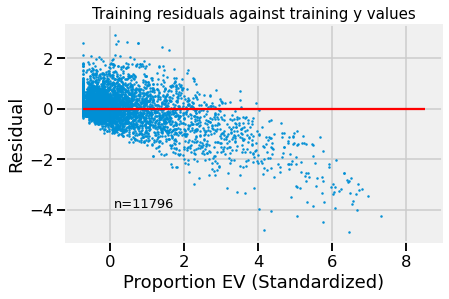

In [52]:
# training (ie NorCal)

residuals = y_pred_train - y_train_stnd

# Scatter the residuals on the y_train values
plt.scatter(y_train_stnd, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Training residuals against training y values", size=15)
plt.hlines(0, y_train_stnd.min(), 8.5, colors="red")
plt.text(0.1, -3.9, "n=6503", size=13);

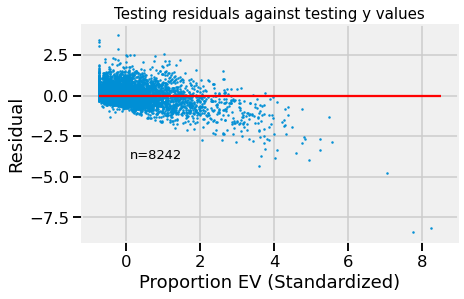

In [54]:
# testing (ie SoCal)

residuals = y_pred_test - y_test_stnd

# Scatter the residuals on the y_test values
plt.scatter(y_test_stnd, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Testing residuals against testing y values", size=15)
plt.hlines(0, y_test_stnd.min(), 8.5, colors="red")
plt.text(0.1, -3.9, "n=8242", size=13);

*These visualizations look very similar to the ones we made when doing our first prediction problem!*

### KFold's Lasso Model
Now we will be try a Lasso model

In [55]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
grid = np.linspace(0.01, 100, 1000)
lasso_model = LassoCV(cv = kf, alphas = grid)
lasso_fit = lasso_model.fit(X_train_stnd, y_train_stnd)


y_pred_lasso_test = lasso_fit.predict(X_test_stnd)
y_pred_lasso_train = lasso_fit.predict(X_train_stnd)
print("test RMSE:", mean_squared_error(y_test_stnd, y_pred_lasso_test, squared = False))
print("train RMSE:", mean_squared_error(y_train_stnd, y_pred_lasso_train, squared = False))
print("R2 test:", r2_score(y_test_stnd, y_pred_lasso_test))
print("R2 train:", r2_score(y_train_stnd, y_pred_lasso_train))
print("alpha:", lasso_fit.alpha_)
lasso_coefs = lasso_fit.coef_
lasso_coefs

/Users/cameronwright/Desktop/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test RMSE: 0.5299523394906485
train RMSE: 0.6711684229268619
R2 test: 0.5792668955443774
R2 train: 0.675683826482044
alpha: 0.01


array([ 0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.02984387, -0.        , -0.03616143, -0.00602279, -0.00437527,
       -0.        ,  0.32516567, -0.        , -0.00712405, -0.        ,
        0.00854898,  0.        , -0.0125975 , -0.00954526,  0.5729909 ,
       -0.        , -0.01512858,  0.        ,  0.06854569, -0.        ,
        0.00505354,  0.        , -0.01562682,  0.00624645,  0.        ,
        0.        , -0.01543041, -0.01838603])

The values we got when we ran this model with a random train-test split were:
[test RMSE: 0.5972230187271781, train RMSE: 0.593714769622557, $R^2$ test: 0.6366273513432918, $R^2$ train: 0.649112454673025, alpha: 0.01]. As you can see, we have a much lower test RMSE, as well as a much higher train RMSE.

*Again, let's visualize how far off each predictions is from the actual obervation.*

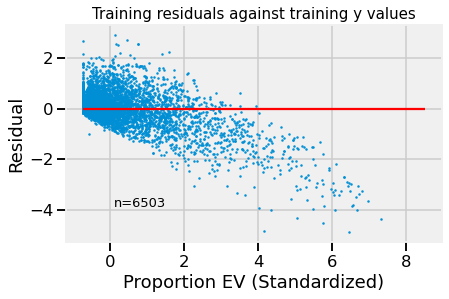

In [57]:
# training (ie NorCal)

y_train_new = [y_train_stnd[i][0] for i in range(len(y_train_stnd))]
y_pred_lasso_train_new = [value for value in y_pred_lasso_train]

residuals = [y_pred_lasso_train_new[i] - y_train_new[i] for i in range(len(y_train_new))]

# Scatter the residuals on the y_train values
plt.scatter(y_train_stnd, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Training residuals against training y values", size=15)
plt.hlines(0, y_train_stnd.min(), 8.5, colors="red")
plt.text(0.1, -3.9, "n=6503", size=13);

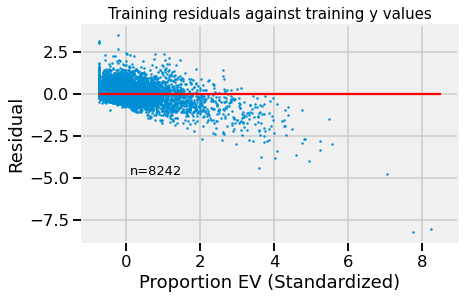

In [60]:
# testing (ie SoCal)

y_test_new = [y_test_stnd[i][0] for i in range(len(y_test_stnd))]
y_pred_lasso_test_new = [value for value in y_pred_lasso_test]

residuals = [y_pred_lasso_test_new[i] - y_test_new[i] for i in range(len(y_test_new))]

# Scatter the residuals on the y_train values
plt.scatter(y_test_stnd, residuals, s=1)

plt.xlabel("Proportion EV (Standardized)")
plt.ylabel("Residual")
plt.title("Training residuals against training y values", size=15)
plt.hlines(0, y_test_stnd.min(), 8.5, colors="red")
plt.text(0.1, -4.8, "n=8242", size=13);

Since our model seems to be predicting fairly similar RMSE and $R^2$ values, we can get a decent sense of how this model could potentially be applied to different states.